# ECE285 - MLIP - Assignment3 -Transfer Learning

### 1. Getting started

In [1]:
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### 2. Data Loader

#### 1. Create a variable dataset root dir and make it point to the Bird dataset directory.

In [3]:
import socket
import getpass

hostname = socket.gethostname()
print(hostname)

username = getpass.getuser()
print(username)

dsmlp-jupyter-qima
qima


In [4]:
dataset_root_dir = '/datasets/ee285f-public/caltech_ucsd_birds/'

#### 2. Interpret and complete the following piece of code:

In [5]:
class BirdsDataset(td.Dataset):

    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(BirdsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})". \
               format(self.mode, self.image_size)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
                                self.data.iloc[idx]['file_path'])
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
            ])
        x = transform(img)
        d = self.data.iloc[idx]['class']
        return x, d

    def number_of_classes(self):
        return self.data['class'].max() + 1


Interpretation:
> Reload the subclass named BirdsDataset of td.Dataset, get the data directory, define __len__ as method to get the length of data, define __repr__ as format of dataset, define __getitem__ to get the image of corresponding index, convert the image to tensor, resize, normalize and finally return the image x and its label d.

#### 3. Copy paste the following function:

In [11]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


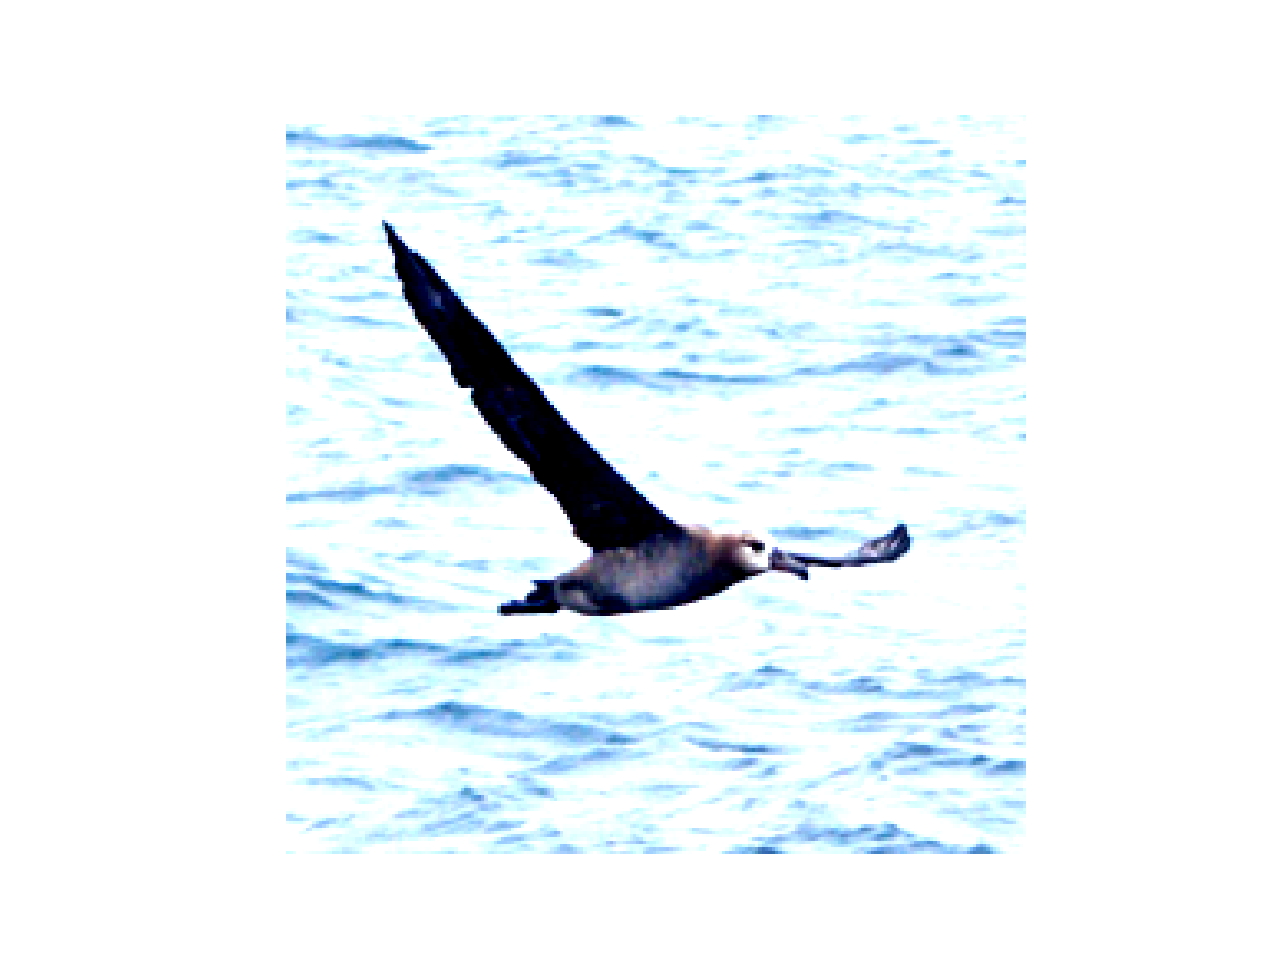

In [12]:
train_set = BirdsDataset(dataset_root_dir, "train")
x, d = train_set.__getitem__(10)
myimshow(x)

#### 4. Advantages of using PyTorch's Dataset

In [13]:
train_loader = td.DataLoader(train_set, shuffle = True, batch_size = 16, pin_memory = True)

Advantages to use *pin_memory = True*: If True, the data loader will copy tensors into CUDA pinned memory before returning them. Thus it will be transferred quickly to cuda afterwards.

How many mini-batches are there?
> 47

In [14]:
import math
math.ceil(len(train_set)/16)

47

#### 5. Display the fist image and label pair of the four first min-batches

<IPython.core.display.Javascript object>


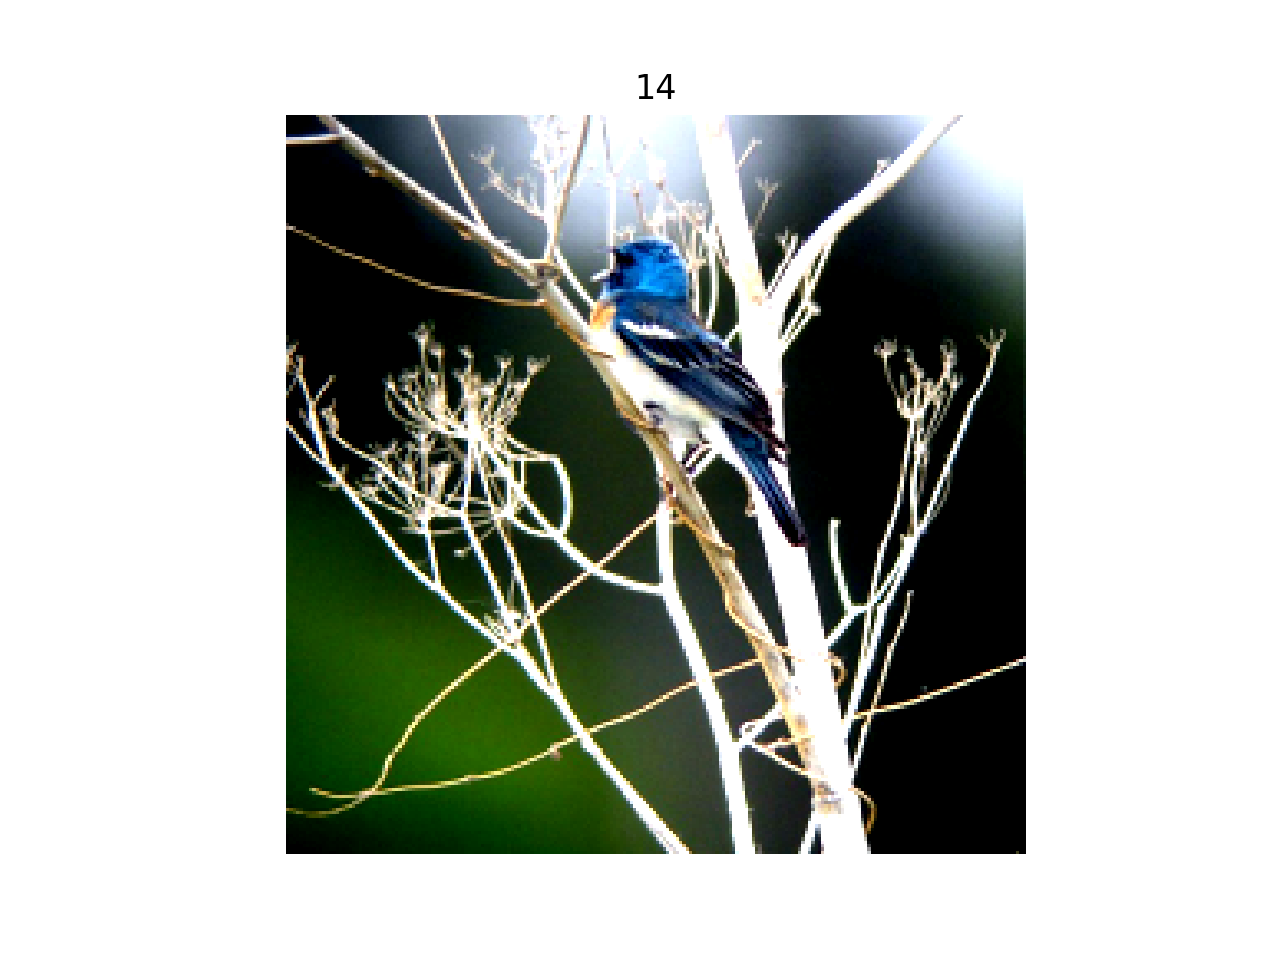

<IPython.core.display.Javascript object>


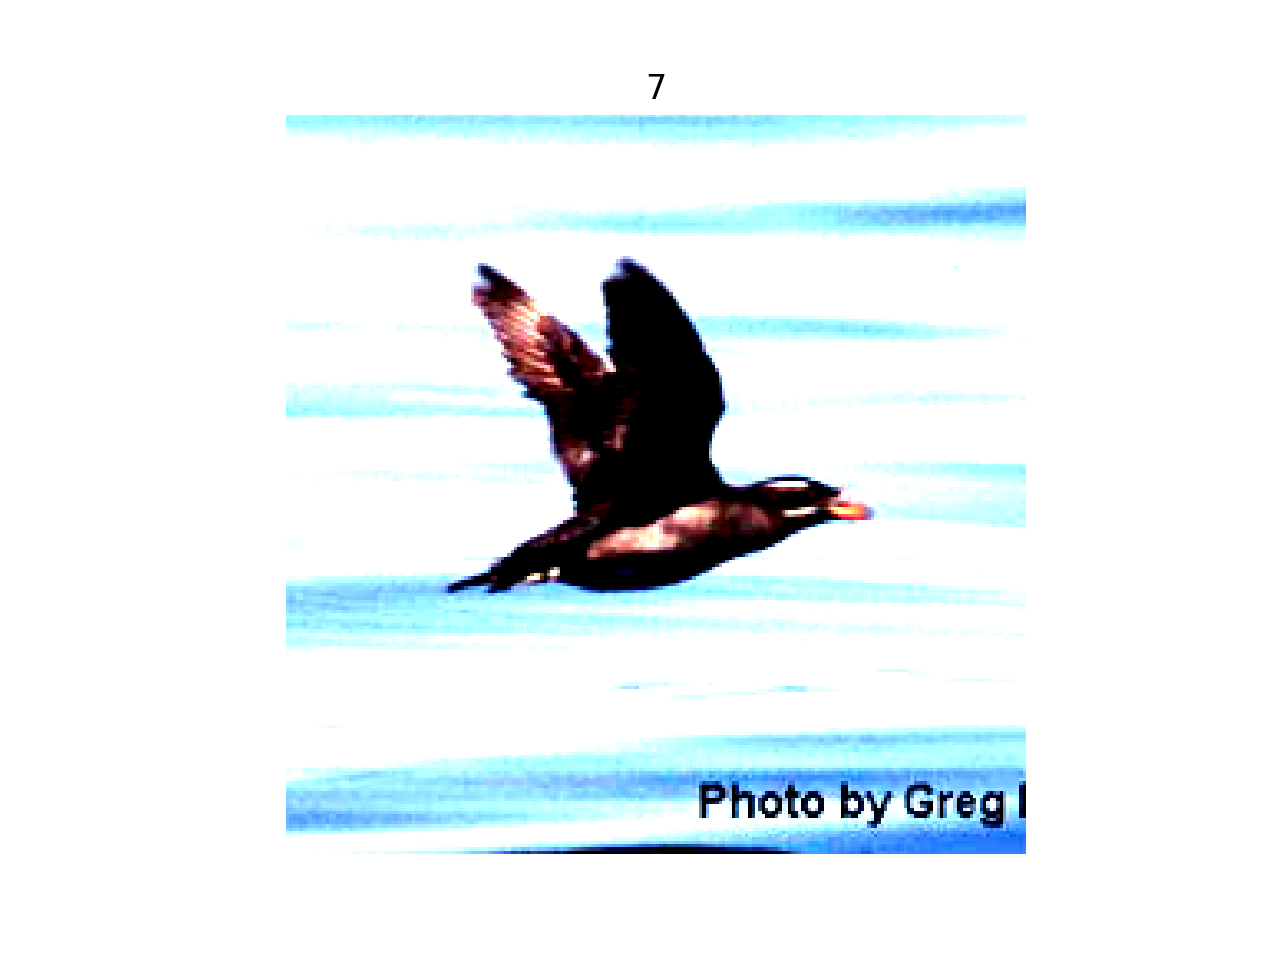

<IPython.core.display.Javascript object>


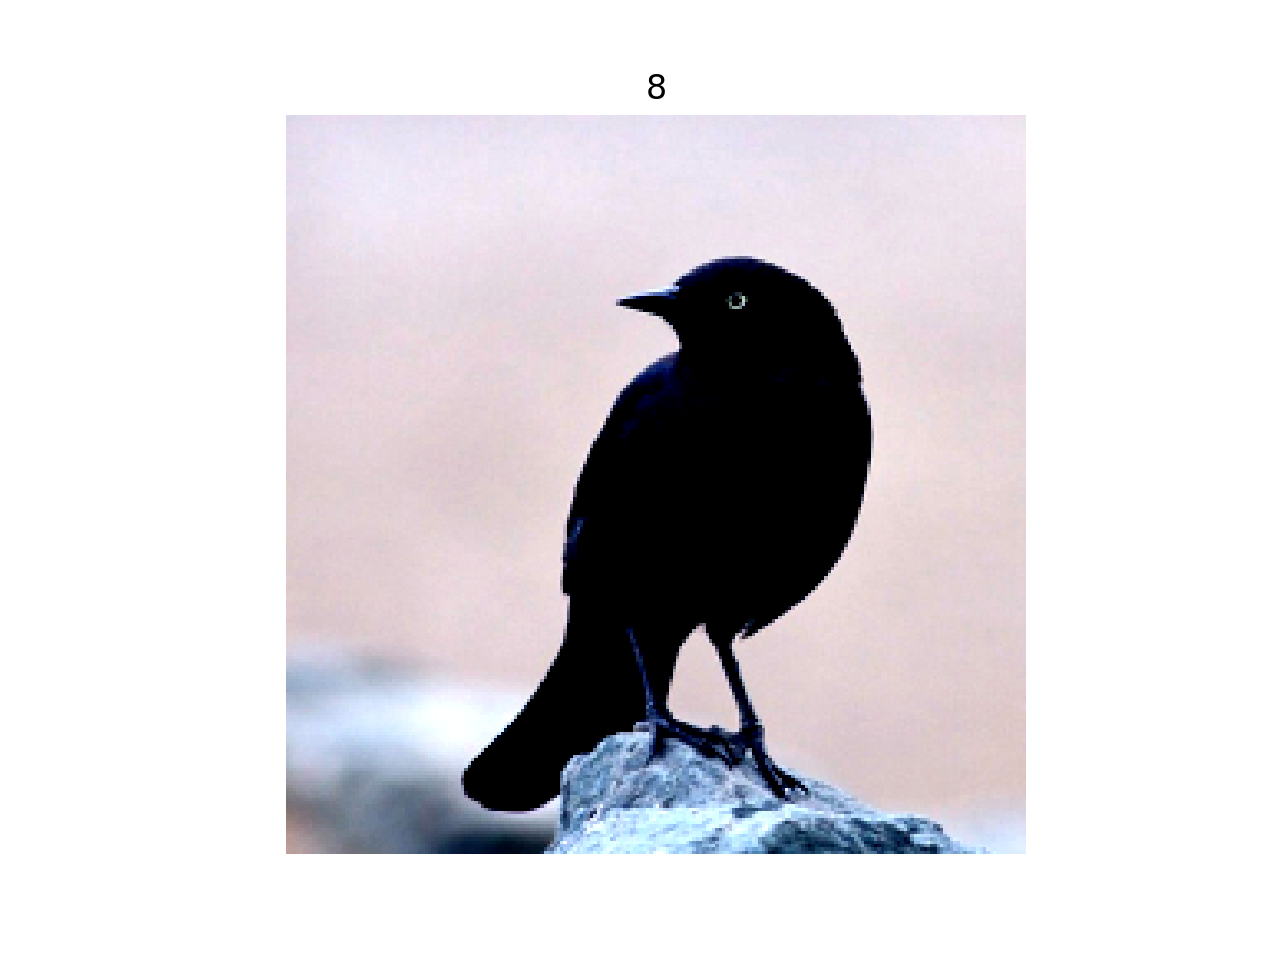

<IPython.core.display.Javascript object>


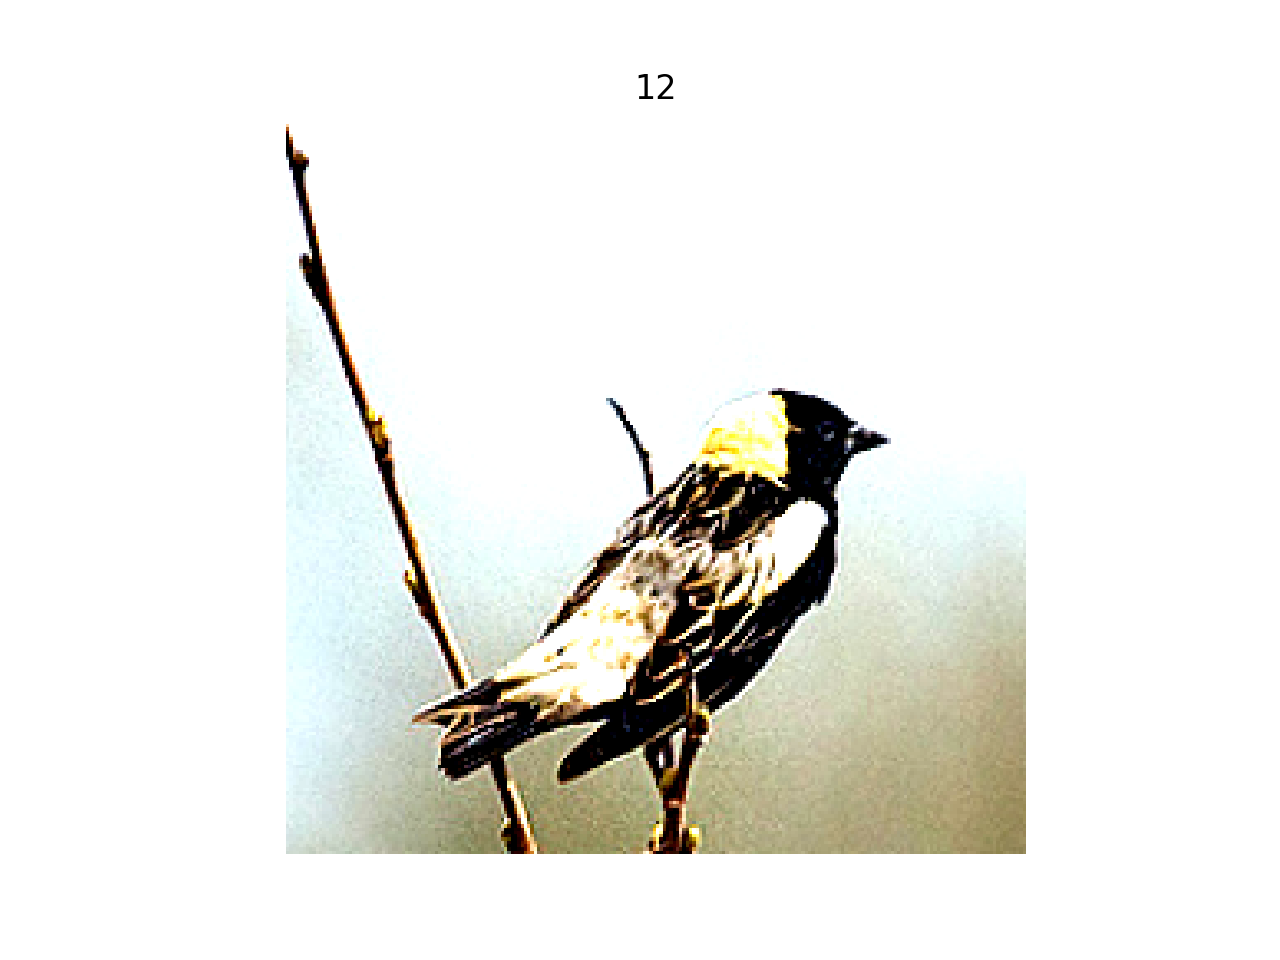

In [16]:
for index, (image, label) in enumerate(train_loader):
    if index < 4:
        plt.figure()
        myimshow(image[0])
        plt.title(str(label[0].numpy()))
    else:
        break

#### 6. Create *val_set* as an instance of *BirdsDataset*

In [13]:
val_set = BirdsDataset(dataset_root_dir, mode = 'val')

In [14]:
val_loader = torch.utils.data.DataLoader(train_set, batch_size = 16, pin_memory = True)

Why do you think we need to shuffle the dataset for training but not for validation?
> You want to shuffle your data after each epoch because you will always have the risk to create batches that are not representative of the overall dataset, and therefore, your estimate of the gradient will be off. Shuffling your data after each epoch ensures that you will not be "stuck" with too many bad batches.

### 3. Abstract Neural Network Model

In [15]:
import nntools as nt

In [16]:
help(nt.NeuralNetwork)

Help on class NeuralNetwork in module nntools:

class NeuralNetwork(torch.nn.modules.module.Module, abc.ABC)
 |  An abstract class representing a neural network.
 |  
 |  All other neural network should subclass it. All subclasses should override
 |  ``forward``, that makes a prediction for its input argument, and
 |  ``criterion``, that evaluates the fit between a prediction and a desired
 |  output. This class inherits from ``nn.Module`` and overloads the method
 |  ``named_parameters`` such that only parameters that require gradient
 |  computation are returned. Unlike ``nn.Module``, it also provides a property
 |  ``device`` that returns the current device in which the network is stored
 |  (assuming all network parameters are stored on the same device).
 |  
 |  Method resolution order:
 |      NeuralNetwork
 |      torch.nn.modules.module.Module
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(s

#### 7. Instantiate a neural network

In [17]:
net = nt.NeuralNetwork()

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward

observe: an abstract class cannot be instantiated.

In [18]:
class NNClassifier(nt.NeuralNetwork):

    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)

### 4. VGG-16 Transfer Learning

#### 8. In your notebook, evaluate the following:

In [19]:
vgg = tv.models.vgg16_bn(pretrained=True)

In [20]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [21]:
for name, param in vgg.named_parameters():
    print(name, param.size(),param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) True
features.3.bias torch.Size([64]) True
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) True
features.7.bias torch.Size([128]) True
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features.18.bi

The parameters in indices 0 and 1 are learnable parameters. <br> Gradients are going to be tracked by autograd for all parameters.

#### 9. Copy/paste the code of *NNClassifier* in your notebook, and create a new sublass *VGG16Transfer* that inherits from *NNClassifier* by completing the following:

In [22]:
class VGG16Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        # COMPLETE
        self.classifier = vgg.classifier
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # COMPLETE
        f = self.features(x)
        #f = self.avgpool(x)
        f = f.view(-1, 25088)
        #f = f.view(x.size(0), -1)
        y = self.classifier(f)
        return y

#### 10. Create an instance of this class for a classiﬁcation problem with a number of classes speciﬁed as *num_classes = train_set.number_of_classes()*.

In [23]:
num_classes = train_set.number_of_classes()

In [24]:
print(num_classes)

20


Print the network and inspect its learnable parameters.

In [25]:
vgg16 = VGG16Transfer(num_classes)

In [26]:
vgg16

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

### 5. Training experiment and checkpoints

#### 11. Create a new subclass *ClassificationStatsManager* that inherits from *StatsManager* and overload each method in order to track the accuracy by completing the following code

In [27]:
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()

    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}

#### 12. Read the documentation https: //pytorch.org/docs/stable/nn.html#torch.nn.Module.eval and explain why we use this.

Some operations (like DropOut and BatchNorm) perform differently on training and testing set, thus we need nn.Module.eval() to distinguish it.

#### 13. Take time to read and interpret carefully the code of Experiment and run the following

In [28]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

Visualize the file config.txt

In [34]:
!cat birdclass1/config.txt

Net(VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [29]:
print(net)

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

interpretation:
> 1. The learning rate is 1e-3
> 2. Instantiate a class VGG16Transfer called net, and the out features is set up as num_classes (20)
> 3. Move net to gpu (cuda)
> 4. Implement Adam algorithm as Stochastic Optimization
> 5. Instantiate a class ClassificationStatsManager called stats_manager
> 6. Instantiate a class Experiment in nntool.py called exp1, the results are stored in output directory 'birdclass1', Create a separate test model to perform validation during training

What does the ﬁle checkpoint.pth.tar correspond to?
> 

#### 14. Change the learning rate to 1e-4 and re-evaluate the cell. What do you observe? Change it back to 1e-3 and re-evaluate the cell. What do you observe? Why?

In [30]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

What do you observe? Why?
> If we try change the learning rate to 1e-4, we can't create the experiment, since a checkpoint conflicts with the existing setting.
> But if change back to 1e-3, there's no error

#### 15. Copy and complete the following code running the experiment for 20 epochs

In [31]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes[0].legend(loc=1)
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                 label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
                 label="evaluation accuracy")
    axes[1].legend(loc=4)
    # COMPLETE
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


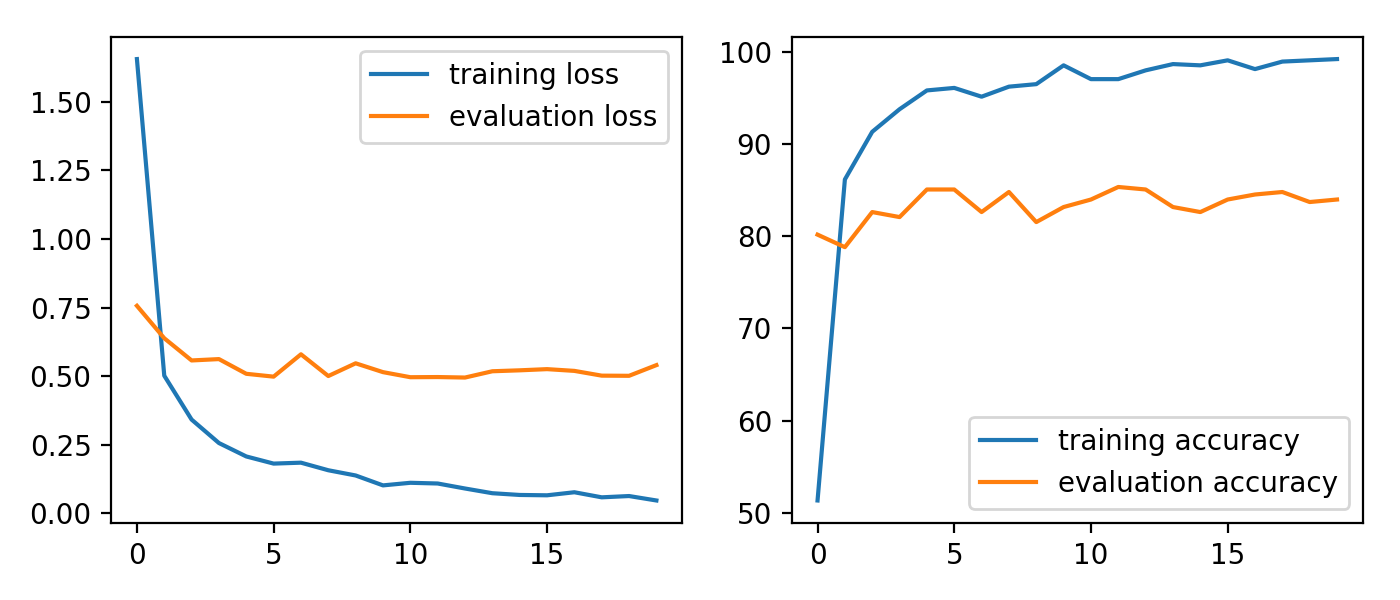

Start/Continue training from epoch 20
Finish training for 20 epochs


In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

### 6. ResNet18 Transfer Learning

In [178]:
resnet = tv.models.resnet18(pretrained=True)

In [179]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

#### 16. Similar to *VGG16Transfer*, create a subclass *ResNet18Transfer* that inherits from *NNClassifier* and that redefines the last FC layer

In [190]:
class ResNet18Transfer(NNClassifier):

    def __init__(self, num_classes, fine_tuning=False):
        super(ResNet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        '''
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        '''
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # COMPLETE
        '''
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        '''
        x = self.features(x)
        x = x.view(-1, 512)
        y = self.fc(x)
        return y

#### 17. Create an instance of Resnet18Transfer and create a new experiment exp2 making backups in the directory birdclass2. Run the experiment for 20 epochs with Adam and learning rate 1e-3 using the same function plot as before.

In [191]:
resnet18 = ResNet18Transfer(num_classes)

In [194]:
lr = 1e-3
net = ResNet18Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass2", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


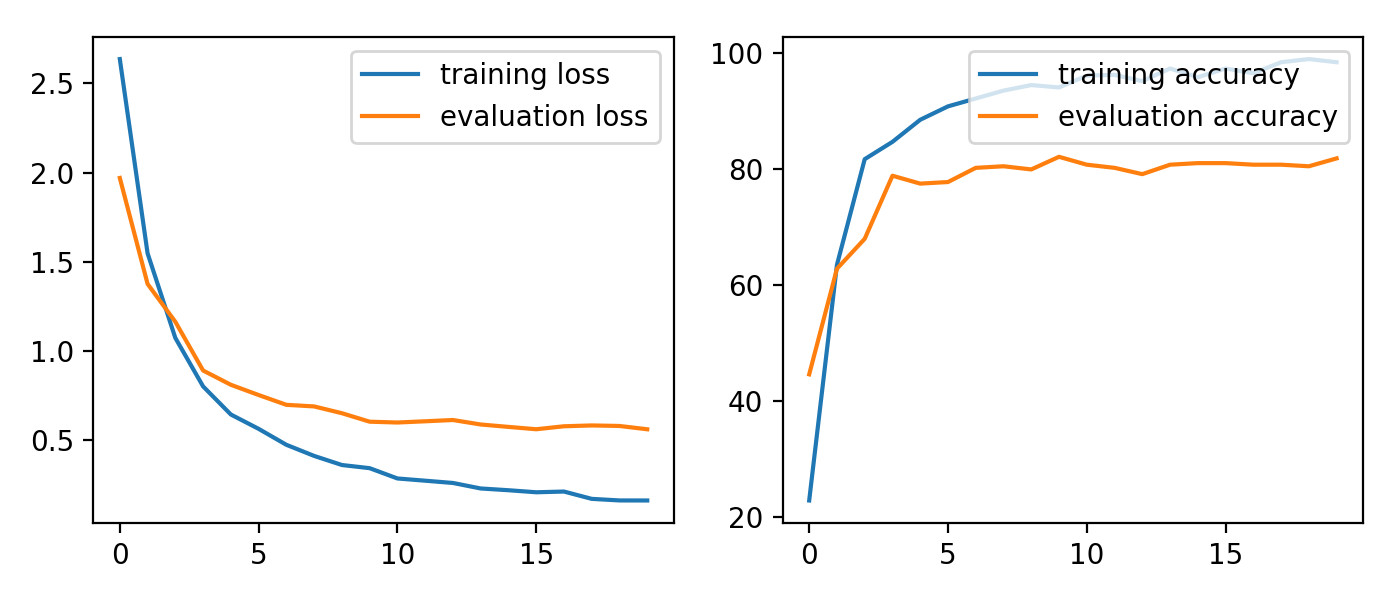

Start/Continue training from epoch 0
Epoch 1 (Time: 14.24s)
Epoch 2 (Time: 20.22s)
Epoch 3 (Time: 20.49s)
Epoch 4 (Time: 19.85s)
Epoch 5 (Time: 20.35s)
Epoch 6 (Time: 20.34s)
Epoch 7 (Time: 20.60s)
Epoch 8 (Time: 20.54s)
Epoch 9 (Time: 20.79s)
Epoch 10 (Time: 20.98s)
Epoch 11 (Time: 20.56s)
Epoch 12 (Time: 20.26s)
Epoch 13 (Time: 20.93s)
Epoch 14 (Time: 20.93s)
Epoch 15 (Time: 20.97s)
Epoch 16 (Time: 20.72s)
Epoch 17 (Time: 20.95s)
Epoch 18 (Time: 20.83s)
Epoch 19 (Time: 20.65s)
Epoch 20 (Time: 21.20s)
Finish training for 20 epochs


In [196]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

#### 18. Using the method evaluate of Experiment, compare the validation performance obtained by exp1 and exp2 using respectively VGG16Transfer and Resnet18Transfer.

In [175]:
exp1.evaluate()

{'loss': 0.5402297465049702, 'accuracy': tensor(83.9674, device='cuda:0')}

In [198]:
exp2.evaluate()

{'loss': 0.5594604744211488, 'accuracy': tensor(81.7935, device='cuda:0')}